In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 458.3 MB 12 kB/s 


In [ ]:
!nvidia-smi

Sun Sep  5 12:17:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    58W / 149W |     58MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import zipfile
zip_path = "/content/drive/MyDrive/Wildfire_TFRecords.zip"
handle = zipfile.ZipFile(zip_path,'r')
handle.extractall('/content/Wildfire_TFRecords')
handle.close()

The Wildfire Project

1.   Libraries
2.   Create the dataset from tfrecord file(s)
3.   Wildfire Dataset TFRecords: import, parse, decode, extract
4.   Use VGG16 CNN for Regression to find Bounding Box
5.   Plot history
6.   IoU and Visualize results



In [3]:
# Import Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from PIL import ImageDraw
from keras.models import model_from_json
import numpy as np
import random

In [4]:
# Parse function
def parse_record(record):
    name_to_features = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'image/object/class/label': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
        'image/object/class/text': tf.io.FixedLenFeature([], tf.string),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(record, name_to_features)

# Decoding function
def decode_record(parsed_record):
    # Image
    image = tf.io.decode_jpeg(parsed_record['image/encoded'], channels=3)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.image.resize(image, (224, 224))
    image = tf.reshape(image, (224, 224, 3))

    # Bounding Box
    xmin = parsed_record['image/object/bbox/xmin'][0]
    ymin = parsed_record['image/object/bbox/ymin'][0]
    xmax = parsed_record['image/object/bbox/xmax'][0]
    ymax = parsed_record['image/object/bbox/ymax'][0]
    bbox = [xmin, ymin, xmax, ymax]

    return image, bbox

In [5]:
def extract_records(record):
    parsed_record = parse_record(record)
    decoded_record = decode_record(parsed_record)

    return decoded_record

def get_dataset(tfrecord_path, set_type):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(extract_records, num_parallel_calls=tf.data.experimental.AUTOTUNE)
   
    return dataset

In [6]:
batch_size = 16

tfrecord_train_path = '/content/Wildfire_TFRecords/train/Smoke.tfrecord'
ds_train = get_dataset(tfrecord_train_path, "train")
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

tfrecord_valid_path = '/content/Wildfire_TFRecords/valid/Smoke.tfrecord'
ds_valid = get_dataset(tfrecord_valid_path, "valid")
ds_valid = ds_valid.batch(batch_size)
ds_valid = ds_valid.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
# Create CNN Model
vgg = VGG16(include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# Freeze all VGG layers so they will *not* be updated during the training process
#vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)

bbox = Dense(256, activation="relu")(flatten)
bbox = Dropout(0.2)(bbox)
bbox = Dense(128, activation="relu")(flatten)
bbox = Dropout(0.2)(bbox)
bbox = Dense(32, activation="relu")(bbox)
bbox = Dense(4, activation="sigmoid")(bbox)

model = Model(inputs=vgg.input, outputs=bbox)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [8]:
# Compiling the CNN
model.compile(optimizer='adam',
              loss='mse')

history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=15,
                    verbose=1,
                    batch_size=batch_size
                    )


Epoch 1/15
33/33 [==============================] - 58s 659ms/step - loss: 0.0422 - val_loss: 0.0329
Epoch 2/15
33/33 [==============================] - 14s 432ms/step - loss: 0.0358 - val_loss: 0.0320
Epoch 3/15
33/33 [==============================] - 14s 431ms/step - loss: 0.0342 - val_loss: 0.0316
Epoch 4/15
33/33 [==============================] - 14s 434ms/step - loss: 0.0339 - val_loss: 0.0318
Epoch 5/15
33/33 [==============================] - 14s 435ms/step - loss: 0.0314 - val_loss: 0.0224
Epoch 6/15
33/33 [==============================] - 14s 434ms/step - loss: 0.0210 - val_loss: 0.0115
Epoch 7/15
33/33 [==============================] - 14s 434ms/step - loss: 0.0147 - val_loss: 0.0115
Epoch 8/15
33/33 [==============================] - 14s 432ms/step - loss: 0.0095 - val_loss: 0.0059
Epoch 9/15
33/33 [==============================] - 14s 435ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 10/15
33/33 [==============================] - 14s 434ms/step - loss: 0.0057 - val_lo

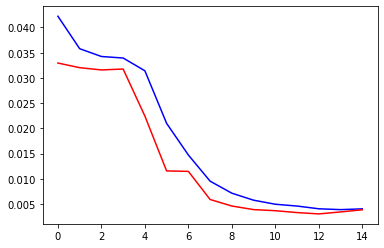

In [9]:
# Plot losses
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')

In [10]:
# Save history
np.save('history.npy',history.history)

# Load history
#history = np.load('history1.npy',allow_pickle='TRUE').item()

In [11]:
def save_model(model,name):
    # Saving the model
    model_json = model.to_json()
    with open(name + ".json", "w") as json_file:
        json_file.write(model_json)
        
    model.save_weights(name + '_wildfire_weights.h5')
    print("Saved model to disk")
    
    return

def load_model(name):
    # Load model
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    model.load_weights(name + "_wildfire_weights.h5")
    print("Loaded model from disk")
    
    return model

In [12]:
# Save model
name = "model"
save_model(model,name)

# Load model
#name = "model"
#model = load_model(name)

Saved model to disk


In [13]:
def show_results(images,true_bboxes,pred_bboxes):
    # Show results
    indexes = random.sample(range(1, len(images)), 6)
    fig = plt.figure(figsize=(12, 6))
    r,c = 2,3
    for i in range(1,len(indexes)+1):
        fig.add_subplot(r,c,i)
        img = images[indexes[i-1]]
        true_bbox = tf.multiply(true_bboxes[indexes[i-1]], 224)
        pred_bbox = tf.math.multiply(pred_bboxes[indexes[i-1]][0], 224)
  
        pil_img = tf.keras.preprocessing.image.array_to_img(img)
        draw = ImageDraw.Draw(pil_img)
        draw.rectangle(list(true_bbox), outline='green', width=1)
        draw.rectangle(list(pred_bbox), outline='red', width=1)
  
        title = 'IoU: '+ str(round(IoU(true_bbox,pred_bbox).numpy(),4))
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pil_img)
    fig.tight_layout(pad=1.0)
    plt.show()

In [14]:
def IoU(y_true, y_pred):
    # Intersection Over Union function
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = y_pred
    xmin_true, ymin_true, xmax_true, ymax_true = y_true

    const = 1e-10

    xmin_overlap = max(xmin_pred, xmin_true)
    ymin_overlap = max(ymin_pred, ymin_true)    
    
    xmax_overlap = min(xmax_pred, xmax_true)
    ymax_overlap = min(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = max((xmax_overlap - xmin_overlap), 0) * max((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + const) / (union_area + const)

    return iou

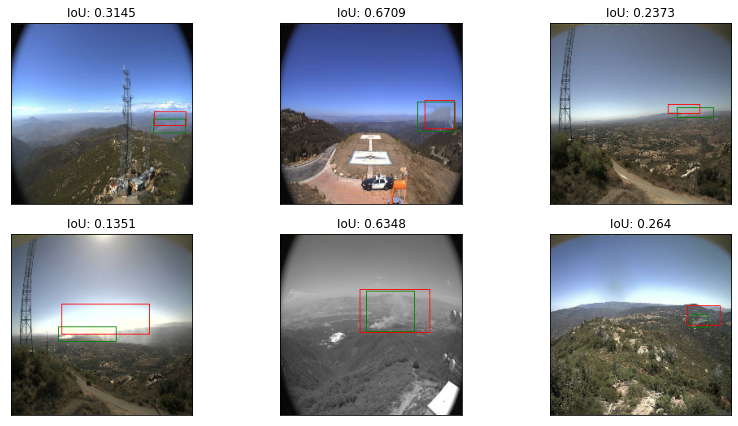

In [17]:
tfrecord_test_path = '/content/Wildfire_TFRecords/test/Smoke.tfrecord'
ds_test = get_dataset(tfrecord_test_path, "test")

images = []
true_bboxes = []
pred_bboxes = []
for example in ds_test:
    img, bbox = example
    images.append(img)
    true_bboxes.append(bbox.numpy())
    pred_bboxes.append(model.predict(tf.reshape(img,(1,224,224,3))))

show_results(images,true_bboxes,pred_bboxes)